# VarMiON for the heat equation with initial condition and Robin boundary condition

**SPDX-License-Identifier: GPL-3.0**  
**Copyright (c) 2025 NLALDlab**  
**Authors: NLALDlab**

\begin{aligned}
    C(\mathbf{x}) \partial_t u(t, \mathbf{x}) -\nabla \cdot (\theta(\mathbf{x}) \nabla u(t, \mathbf{x})) &= f(t, \mathbf{x}) \quad \forall (t,\mathbf{x}) \in (0,T) \times \Omega \\
    - \theta(\mathbf{x}) \frac{\partial u(t, \mathbf{x})}{\partial \mathbf{n}} &= h (u(t, \mathbf{x}) - g(t, \mathbf{x})) \quad \forall (t,\mathbf{x}) \in (0,T) \times \partial \Omega \\
    u(0, \mathbf{x}) &= u_0(\mathbf{x}) \quad \forall \mathbf{x} \in \Omega
\end{aligned}


where
\begin{aligned}
     \Omega = [0,1]^2  \\
\end{aligned}

and $u$ is the temperature

In [1]:
import torch, math, os, time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import stats
import seaborn as sns
from datetime import datetime
import pickle

from torch import nn
from torch.utils.data import random_split, DataLoader
import torch.optim as optim

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
from abc import ABC, abstractmethod

from sympy.utilities.iterables import multiset_permutations
from itertools import product

In [2]:
# packages needed:
# numpy, torch, sympy
# for graphical content: matplotlib, scipy, seaborn

# nb works with versions:
# python: 3.11.10
# numpy: 1.26.4
# torch: 2.5.1
# sympy: 1.13.1
# matplotlib: 3.9.2
# scipy: 1.14.1
# seaborn: 0.13.2

#python
import sys
print(f"{sys.version = }")
# numpy
import numpy
print(f"{numpy.__version__ = }")
# torch
print(f"{torch.__version__ = }")
# sympy
import sympy
print(f"{sympy.__version__ = }")
# matplotlib
import matplotlib
print(f"{matplotlib.__version__ = }")
#scipy
import scipy
print(f"{scipy.__version__ = }")
# seaborn
import seaborn
print(f"{seaborn.__version__ = }")

sys.version = '3.11.10 (main, Oct  3 2024, 07:29:13) [GCC 11.2.0]'
numpy.__version__ = '1.26.4'
torch.__version__ = '2.5.1'
sympy.__version__ = '1.13.1'
matplotlib.__version__ = '3.9.2'
scipy.__version__ = '1.14.1'
seaborn.__version__ = '0.13.2'


In [3]:
# GPU check
print(f"{torch.cuda.is_available() = }")
#print(f"{torch.cuda.device_count() = }")
#print(f"{torch.cuda.current_device() = }")
#current_device = torch.cuda.current_device()
#print(f"{torch.cuda.device(current_device) = }")
#print(f"{torch.cuda.get_device_name(current_device) = }")
#print("\n")
#
## to check NVIDIA's CUDA compiler (nvcc) version
#!nvcc --version

torch.cuda.is_available() = True


# Error and Loss Function

In [4]:
# Used for computing the error in the test dataset
class VarMiONLossTime(torch.nn.Module):
    def __init__(self, n_grid_pts, n_bry_pts, times, J, tdim):
        super().__init__()
        self.n_grid_pts = n_grid_pts
        self.n_bry_pts = n_bry_pts
        self.J = J
        self.tdim = tdim
                
        self.T = times[-1] - times[0]
        self.n_times = len(times)       
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        self.weights = self.quadrature_time(N=self.tdim+1, T=self.T, m=self.n_times-1, n=self.n_grid_pts-1)
        
    def quadrature_time(self, N, T, m, n):
        # N = space dimension of [0,T] x [0,1]^(N-1)
        # t = 0 initial time
        # T = final time
        # m = #subintervals in [0,T]
        # n = #subintervals in [0,1]
    
        
        def vertices(N): 
            return list(product((0, 1), repeat=N))
    
        def create_mesh(N, t_vec, x_vec):
            x_mesh = np.array(list(product(x_vec, repeat=N-1)))
            return [np.append(t,x) for t in t_vec for x in x_mesh]
        
        
        V = np.ones((N,N+1))
        V = np.tril(V)
    
        M = vertices(N)
        M = np.array(M).T
        x = np.zeros(2**N)
    
        for sigma in multiset_permutations(np.arange(N)):
            V_sigma = V.copy()
            V_sigma = V[sigma,:]
            for i in range(N+1):
                tmp = np.all(V_sigma[:,i] == M.T, axis = 1)
                j = np.where(tmp)[0][0]
                x[j] += 1
            #endfor
        #endfor
    
        t_vec = np.arange(0,m+1)
        x_vec = np.arange(0,n+1)
        points = np.array(create_mesh(N, t_vec, x_vec)).T
    
        num_points = (m+1)*((n+1)**(N-1))
        y = np.zeros(num_points)


        for i in range(m):
            for valori in product(np.arange(0,n), repeat=N-1):
                M_tmp = M.copy()
                M_tmp[0,:] += i
                for j in range(1,N):
                    M_tmp[j,:] += valori[j-1]
                #endfor
                
                for k in range(2**N):
                    tmp = np.all(M_tmp[:,k] == points.T, axis = 1)
                    indice_vertice = np.where(tmp)[0][0]
                    y[indice_vertice] += x[k]
                #endfor
            #endfor
        #endfor
        
        num_simplessi = math.factorial(N) * m * n**(N-1)
        c = T / ((N+1) * num_simplessi)

        # weights w
        w = c*y        
        w = w[(n+1)**(N-1):]
        
        return w

    def forward(self, input, target):
        W = torch.tile(self.weights, (self.J,)).to(self.device)
        diff = target[:,:,:(self.n_grid_pts)**self.tdim] - input[:,:,:(self.n_grid_pts)**self.tdim]    
        return torch.sum(W * diff.view(-1)**2)/self.J

In [5]:
# loss function
class VarMiONLossTimeBry(torch.nn.Module):
    def __init__(self, n_grid_pts, n_bry_pts, times, J, tdim, lam=0, goal_oriented = False):
        super().__init__()
        self.n_grid_pts = n_grid_pts
        self.n_bry_pts = n_bry_pts
        self.J = J
        self.tdim = tdim
        self.lam = lam
        self.goal_oriented = goal_oriented
                
        self.T = times[-1] - times[0]
        self.n_times = len(times)       
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        self.weights = self.quadrature_time(N=self.tdim+1, T=self.T, m=self.n_times-1, n=self.n_grid_pts-1)
        
    def quadrature_time(self, N, T, m, n):
        # N = space dimension of [0,T] x [0,1]^(N-1)
        # t = 0 initial time
        # T = final time
        # m = #subintervals in [0,T]
        # n = #subintervals in [0,1]
    
        
       def goal_function(): #goal: line y=0
           section_indices = []
           for i in range(n):
               section_indices.append([x for x in range(n*i,n*(i+1))])
           #endfor
           alpha = 1e6
           phi = np.ones((n+1)**self.tdim)
           for i,index in enumerate(section_indices):
               phi[index] = alpha**(1-i/n)
           #endfor
           phi = np.tile(phi, m)
           return phi
    
        def vertices(N): 
            return list(product((0, 1), repeat=N))
    
        def create_mesh(N, t_vec, x_vec):
            x_mesh = np.array(list(product(x_vec, repeat=N-1)))
            return [np.append(t,x) for t in t_vec for x in x_mesh]
        
        
        V = np.ones((N,N+1))
        V = np.tril(V)
    
        M = vertices(N)
        M = np.array(M).T
        x = np.zeros(2**N)
    
        for sigma in multiset_permutations(np.arange(N)):
            V_sigma = V.copy()
            V_sigma = V[sigma,:]
            for i in range(N+1):
                tmp = np.all(V_sigma[:,i] == M.T, axis = 1)
                j = np.where(tmp)[0][0]
                x[j] += 1
            #endfor
        #endfor
    
        t_vec = np.arange(0,m+1)
        x_vec = np.arange(0,n+1)
        points = np.array(create_mesh(N, t_vec, x_vec)).T
    
        num_points = (m+1)*((n+1)**(N-1))
        y = np.zeros(num_points)


        for i in range(m):
            for valori in product(np.arange(0,n), repeat=N-1):
                M_tmp = M.copy()
                M_tmp[0,:] += i
                for j in range(1,N):
                    M_tmp[j,:] += valori[j-1]
                #endfor
                
                for k in range(2**N):
                    tmp = np.all(M_tmp[:,k] == points.T, axis = 1)
                    indice_vertice = np.where(tmp)[0][0]
                    y[indice_vertice] += x[k]
                #endfor
            #endfor
        #endfor
        
        num_simplessi = math.factorial(N) * m * n**(N-1)
        c = T / ((N+1) * num_simplessi)

        # weights w
        w = c*y
        
        w = w[(n+1)**(N-1):]
        
        if self.goal_oriented == True:
            phi = goal_function()
            g_o_w = w*phi #goal oriented weights
            w = g_o_w/sum(g_o_w)*sum(w) #weights are normalized

        return w

    def forward(self, input, target):
        W = torch.tile(self.weights, (self.J,)).to(self.device)

        grid_diff = target[:,:,:(self.n_grid_pts)**self.tdim] - input[:,:,:(self.n_grid_pts)**self.tdim]
        bry_diff = target[:,:,(self.n_grid_pts)**self.tdim:] - input[:,:,(self.n_grid_pts)**self.tdim:]
        
        if self.n_bry_pts==0:
            diff = target[:,:,:(self.n_grid_pts)**self.tdim] - input[:,:,:(self.n_grid_pts)**self.tdim]    
            return torch.sum(W * diff.view(-1)**2)/self.J         
        else:
            grid_diff = target[:,:,:(self.n_grid_pts)**self.tdim] - input[:,:,:(self.n_grid_pts)**self.tdim]
            bry_diff = target[:,:,(self.n_grid_pts)**self.tdim:] - input[:,:,(self.n_grid_pts)**self.tdim:]
            return (torch.sum(grid_diff.view(-1)**2)/grid_diff.view(-1).numel() + self.lam*torch.sum(bry_diff.view(-1)**2)/bry_diff.view(-1).numel())/self.J

                
                

# Customized Dataset Class

In [6]:
class dataset_heat_eq_robin(torch.utils.data.Dataset):
    def __init__(self, dataset_settings_dict):
        super().__init__()
                        
        self.num_pdes = dataset_settings_dict['num_pdes'] # integer equal to the number of instances of the pde to be considered
        data_dir = dataset_settings_dict['data_dir'] # path of the directory containing the dataset
        
        
        with open(data_dir + '/eval_pts', 'rb') as file:
            self.param_pts = np.load(file) # coords of the points used to sample the parameters
            self.param_bry_pts = np.load(file) # coords of the points used to sample the parameters defined on the boundary
            self.temp_pts = np.load(file) # coords of the points used to sample the temperature
            self.times = np.load(file) # array of the times considered in the dataset (includes t=0)
            self.nb = np.load(file) # if not zero: number of points on the boundary (apart from the ones in temp_pts) used to sample the temperature
        #print("nb = ", self.nb)
        
        self.n_param_pts = self.param_pts.shape[0]
        self.n_param_bry_pts = self.param_bry_pts.shape[0]
        self.n_temp_pts = self.temp_pts.shape[0]
        self.n_times = len(self.times)
        
        self.tdim = self.temp_pts.shape[1]
             
        self.data = dict(
            f = np.zeros(shape = (self.num_pdes, self.n_times-1, self.n_param_pts), dtype = np.float32),
            theta = np.zeros(shape = (self.num_pdes, self.n_param_pts), dtype = np.float32),
            c = np.zeros(shape = (self.num_pdes, self.n_param_pts), dtype = np.float32),
            g = np.zeros(shape = (self.num_pdes, self.n_times-1, self.n_param_bry_pts), dtype = np.float32),
            h = np.zeros(shape = (self.num_pdes), dtype = np.float32),
            u0 = np.zeros(shape = (self.num_pdes, self.n_times-1, self.n_temp_pts), dtype = np.float32),
            solution = np.zeros(shape = (self.num_pdes, self.n_times-1, self.n_temp_pts), dtype = np.float32),
        )
        
        self.dir_record = lambda t: f"{data_dir}/record_{t}.npy"
       
        self.check_files_exist()
                   
        for i in range(self.num_pdes):
            self.load_data(i)
        #endfor
                
        self.data = {k: torch.tensor(v, device='cpu', dtype=torch.float32) for k, v in self.data.items()}
        self.temp_pts = torch.tensor(self.temp_pts, device='cpu', dtype=torch.float32)
        self.times = torch.tensor(self.times, device='cpu', dtype=torch.float32)
        
        times_tensor = self.times[1:].view(self.n_times-1, 1, 1).expand(-1, self.n_temp_pts, 1) # size: (n_times-1,n_eval,1)
        points_tensor = self.temp_pts.unsqueeze(0).expand(self.n_times-1, -1, -1) # size: (n_times-1, n_eval, d)        
        self.nodes_tx = torch.cat((times_tensor, points_tensor), dim=-1) # size: (n_times-1, n_eval, 1+d)               
        print("Dataset loaded")
                       
    def __len__(self):
        return self.num_pdes
  
    def load_data(self, i: int) -> None:
        with open(self.dir_record(i), 'rb') as file:
                    
            self.data["c"][i,:] = np.load(file)
            self.data["theta"][i,:] = np.load(file)
            self.data["f"][i,:,:] = np.load(file)
            self.data["h"][i] = np.load(file)
            self.data["g"][i,:,:] = np.load(file)
            tmp = np.load(file) # solution
        
        self.data["u0"][i,:] = tmp[:-1,:]
        self.data["solution"][i,:,:] = tmp[1:,:]
        
    def check_files_exist(self) -> bool:
        for i in range(self.num_pdes):
            if not os.path.exists(self.dir_record(i)):
                print(f"check {i}: False", )
                return False
        print("Dataset files found...")
        return True

    def __getitem__(self, idx):
        
        input_tx = self.nodes_tx
        input_c = self.data['c'][idx, :] 
        input_theta = self.data['theta'][idx, :]      
        input_f = self.data['f'][idx, :, :]
        input_h = self.data['h'][idx]
        input_g = self.data['g'][idx, :, :]
        if self.nb==0:
            input_u0 = self.data['u0'][idx,:,:]
        else:
            input_u0 = self.data['u0'][idx,:,:-self.nb]
        output = self.data['solution'][idx, :, :]
        
        #print("__getitem__")
        #print(f"{input_tx.size() = }")
        #print(f"{input_c.size() = }")
        #print(f"{input_theta.size() = }")
        #print(f"{input_f.size() = }")
        #print(f"{input_h.size() = }")
        #print(f"{input_g.size() = }")
        #print(f"{input_u0.size() = }")
        #print(f"{output.size() = }")
        
        return input_tx, input_c, input_theta, input_f, input_h, input_g, input_u0, output

# Neural Network Model

In [7]:
class HeatEquationVarMiONRobin(nn.Module):
    def __init__(self):
        super().__init__()
            
        self.c_branch = nn.Sequential(
            nn.Linear(in_features=100, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=100)           
        )       
        
        self.theta_branch = nn.Sequential(
            nn.Linear(in_features=100, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=100)           
        )

        self.h_branch = nn.Sequential(
            nn.Linear(in_features=100, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=100)           
        )
      
               
        self.f_branch = nn.Sequential(
            nn.Linear(in_features=100, out_features=64)
        )
        
        self.gh_branch = nn.Sequential(
            nn.Linear(in_features=36, out_features=64)
        )
        
        
        self.u0_branch = nn.Sequential(
            nn.Linear(in_features=100, out_features=64)         
        )    
        

        self.inversion_net = nn.Sequential(
            nn.Unflatten(1, (1, 10, 10)), 
            nn.ConvTranspose2d(in_channels=1, out_channels=8, kernel_size=4, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.ConvTranspose2d(in_channels=8, out_channels=16, kernel_size=4, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(in_channels=16,out_channels= 8, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Unflatten(1,(64,64))
        )

        self.trunk_branch = nn.Sequential(
            nn.Linear(in_features=3, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=64)
        )

    def forward(self, inputs):
        input_tx, input_c, input_theta, input_f, input_h, input_g, input_u0 = inputs
        
        #print("nn forward")
        #print("input_tx", input_tx.size())
        #print("input_c", input_c.size())
        #print("input_theta", input_theta.size())
        #print("input_f", input_f.size())
        #print("input_h", input_h.size())
        #print("input_g", input_g.size())
        #print("input_u0", input_u0.size())
        
        c_branch = self.c_branch(input_c)
        #print("c_branch ", c_branch.size())
        
        theta_branch = self.theta_branch(input_theta)
        #print("theta_branch ", theta_branch.size())
              
        h_branch = self.h_branch(input_h.view(-1,1).expand(-1, 100))
        #print(f"{h_branch.size() = }")
        
        sum_branch = c_branch + theta_branch + h_branch
        #print(f"{sum_branch.size() = }")
        
        inversion_net = self.inversion_net(sum_branch)
        #print(f"{inversion_net.size() = }")
        
        f_branch = self.f_branch(input_f)
        #print(f"{f_branch.size() = }")
                
        gh_branch = input_h.view(-1,1,1) * self.gh_branch(input_g)
        #print(f"{gh_branch.size() = }")
        
        u0_branch = self.u0_branch(input_u0)
        #print(f"{u0_branch.size() = }")
        
        sum_rhs = f_branch + gh_branch + u0_branch
        #print(f"{sum_rhs.size() = }")
        
        trunk = self.trunk_branch(input_tx)
        #print(f"{trunk.size() = }")
        
        sum_rhs = sum_rhs.unsqueeze(-1)
        #print(f"unsqueeze {sum_rhs.size() = }")
        
        inversion_net = inversion_net.unsqueeze(1)
        #print(f"unsqueeze {inversion_net.size() = }")
        
        output = torch.matmul(inversion_net, sum_rhs)
        #print(f"coeff {output.size() = }")
        
        output = output.unsqueeze(2)
        #print(f"unsqueeze {output.size() = }")
        
        trunk = trunk.unsqueeze(3)
        #print(f"unsqueeze {trunk.size() = }")
        
        output = torch.matmul(trunk, output)
        #print(f"basis {output.size() = }")
        
        output = output.squeeze(-1).squeeze(-1)
        #print(f"squeeze {output.size() = }") 

        return output

# VarMiON Class for training/validation/testing of a Variationally Mimetic Operator Network

In [8]:
class VarMiON():
    def __init__(self, dataset, training_parameters_dict):
        
        self.training_parameters_dict = training_parameters_dict
        self.dataset = dataset
        self.tdim = dataset.tdim        
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'        
        print(f"Device = {self.device}")       
        
        self.n_grid_pts = int(np.sqrt(self.dataset.n_temp_pts - self.dataset.nb))
        
        self.loss_err = VarMiONLossTime(n_grid_pts = self.n_grid_pts, n_bry_pts = self.dataset.nb, times=self.dataset.times, J=1, tdim=self.tdim)
           
        self.lam = 0
        self.epoch = 0
           
        # compute the size of the dataset and of the training, validation and testing sub-datasets
        train_fraction = 0.8
        val_fraction = 0.1
        test_fraction = 0.1
        
        n_total = len(self.dataset)
        n_train = int(n_total*train_fraction)
        n_val = int(n_total*val_fraction)
        n_test = int(n_total*test_fraction)      
        
        print(f"Number of PDE instances in the dataset: {n_total}") 
        print(f"Used for the training: {n_train}")
        print(f"Used for the validation: {n_val}")
        print(f"Used for the testing: {n_test}") 
                
        generator = torch.Generator().manual_seed(42)
        self.train_data, self.val_data, self.test_data = random_split(self.dataset, [train_fraction,val_fraction,test_fraction], generator=generator)
            
        # these tensors will contain the value of the loss function at each epoch
        self.losses = ...
        self.val_losses = ...   
        
        self.best_epoch = 0       
        self.test_error_best = torch.zeros(n_test).to(self.device) # contains relative error
        self.test_abs_error_best = torch.zeros(n_test).to(self.device) # contains absolute error     
    
    def train_step_fn(self, X, y):
        self.model.train()
                
        pred = self.model(X)        
        loss = self.loss_fn(pred, y)
        
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        
        return loss.item()
    
    

    def val_step_fn(self, X, y):
        self.model.eval()
        
        pred = self.model(X)                   
        loss = self.loss_fn(pred, y)
          
        return loss.item()

    
    
    def test_step_fn(self, X, y):
        self.model.eval()
        
        pred = self.model(X)                   
        loss = self.test_loss_fn(pred, y)
        
        
        # compute relative error
        y_quad = self.loss_err(y, torch.zeros(y.shape).to(self.device))
        diff_quad = self.loss_err(pred, y)
        
        self.test_error_best[self.counter_test] = torch.sqrt(diff_quad/y_quad)
        self.test_abs_error_best[self.counter_test] = torch.sqrt(diff_quad)
        
        self.counter_test += 1
                
        return loss.item()

    def _mini_batch(self, mode):
        if mode=="validation":
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        elif mode=="training":
            data_loader = self.train_loader
            step_fn = self.train_step_fn
        elif mode=="testing":
            data_loader = self.test_loader
            step_fn = self.test_step_fn
        #endif

        mini_batch_losses = []
        
        
        for j, my_data in enumerate(data_loader):
    
            #print("__minibatch__")
            #for i, x in enumerate(my_data):
            #    print(f"input {i}: \t {x.size()}")
            ##endfor
            #print()
                
            X = [elem.to(self.device) for elem in my_data[:-1]]
            y = my_data[-1].to(self.device)    
            
            mini_batch_loss = step_fn(X,y)
            mini_batch_losses.append(mini_batch_loss)
        #endfor
                                     
        loss = np.mean(mini_batch_losses)
        return loss
    
    
    def _train(self, n_epochs, seed=1):

        for epoch in range(n_epochs):
            print(f"Epoch {epoch+1}/{n_epochs}")
            
            start_epoch = time.time()            
            self.epoch = epoch
            
            # training
            loss = self._mini_batch(mode="training")
            self.losses[epoch] = loss                                   

            with torch.no_grad():                
                # validation
                val_loss = self._mini_batch(mode="validation")
                self.val_losses[epoch] = val_loss
                
                if val_loss < self.val_loss_min:
                    self.best_epoch = epoch
                    self.val_loss_min = val_loss
                    torch.save(self.model.state_dict(), 'model_weights_best.pth')
                #endif
                                              
            if self.verbose:
                print(f"{'Loss':<15}= {val_loss:.18f}")
                print(f"{'Lowest loss':<15}= {self.val_loss_min:.18f} at epoch {self.best_epoch+1}")
                print(f"Elapsed time = {(time.time() - start_epoch):.2f} s")
                print()                
            #endif
            
                      
    def training_validation(self, verbose=False):
        
        start_timer = time.time()
                        
        n_epochs = self.training_parameters_dict['n_epochs']
        self.pdes_per_batch = self.training_parameters_dict['pdes_per_batch']
        self.verbose = verbose
              
        self.train_loader = DataLoader(self.train_data, batch_size=self.pdes_per_batch, shuffle=True)
        self.val_loader = DataLoader(self.val_data, batch_size=self.pdes_per_batch)
        
               
        # these tensors will contain the value of the loss function at each epoch
        self.losses = torch.zeros(n_epochs).to(self.device)
        self.val_losses = torch.zeros(n_epochs).to(self.device)
        self.val_loss_min = float('inf')                   
                      
        self.loss_fn = VarMiONLossTimeBry(n_grid_pts = self.n_grid_pts, n_bry_pts = self.dataset.nb, times=self.dataset.times, J=self.pdes_per_batch, tdim = self.tdim, lam = self.lam, goal_oriented = self.training_parameters_dict['goal_oriented'])
                     
        # create the model and send it to device
        self.model = HeatEquationVarMiONRobin()
        self.model.to(self.device)
                
        # compute total number of parameters
        total_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        print("Number of parameters of the NN: ", total_params, "\n")
        
        # define the optimizer
        self.optimizer = torch.optim.Adam(self.model.parameters()) 

        # training
        self._train(n_epochs)
                        
        self.losses = self.losses.detach().cpu().numpy()
        self.val_losses = self.val_losses.detach().cpu().numpy()
                
        print(f"\n Total elapsed time: {(time.time() - start_timer):.2f} s")
        
        
        
        
        
    def plot_losses(self, save_dir = None):
                                     
        fig, ax = plt.subplots()
        ax.plot(varmion.losses, '-r', label='Training')
        ax.plot(varmion.val_losses, '-b', label='Validation')
        ax.set_title("Training and Validation Loss")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.legend()
        ax.grid()

        if save_dir is not None:
            fig.savefig(save_dir + '/losses.png', bbox_inches='tight')
            np.save(save_dir + '/training_losses', self.losses)
            np.save(save_dir + '/val_losses', self.val_losses)
        
              
    def testing(self, plots = True, save_dir = None):
            
        # create the model and send it to device
        self.model = HeatEquationVarMiONRobin()
        self.model.to(self.device)
        
        # load the best model's weights
        self.model.load_state_dict(torch.load('model_weights_best.pth', weights_only=True))
        self.model.eval()
                
        self.test_loader = DataLoader(self.test_data, batch_size=1)
        self.test_loss_fn = VarMiONLossTimeBry(n_grid_pts = self.n_grid_pts, n_bry_pts = self.dataset.nb, times=self.dataset.times, J=1, tdim = self.tdim, lam = self.lam, goal_oriented = self.training_parameters_dict['goal_oriented'])
       
        with torch.no_grad():
            
            self.counter_test = 0
            self.test_loss_best = self._mini_batch(mode="testing") # it computes self.test_error_best too
            
        self.test_error_best_numpy = self.test_error_best.detach().cpu().numpy()
        self.test_abs_error_best_numpy = self.test_abs_error_best.detach().cpu().numpy()
        
        
        if plots:
            err_rel = self.test_error_best_numpy*100
            print("Relative error on the test dataset")                  
            print(f"Mean: {np.mean(self.test_error_best_numpy)*100:.2f} %")
            print(f"std:  {np.std(self.test_error_best_numpy)*100:.2f} %")
            print()
                
            density = stats.gaussian_kde(err_rel)
            x = np.linspace(min(err_rel), max(err_rel), 100)
                            
            fig1, ax1 = plt.subplots()
            ax1.plot(x, density(x), color='C0')
            ax1.hist(err_rel, bins=15, density=True, color='C0', alpha=0.8)
            ax1.set_title(r'Probability density of the relative $L_2$ error - testing dataset')
            ax1.set_xlabel(r'% Relative $L_2$ error')
            ax1.set_ylabel('Density')
            ax1.set_xlim(0., max(err_rel)+0.1)
            ax1.grid()
            
            if save_dir is not None:
                fig1.savefig(save_dir + "/density_relative_error.png", bbox_inches='tight')
            
            fig2, ax2 = plt.subplots(figsize=(14, 1))  
            
            rug = sns.rugplot(err_rel, height=1, color='C0', label='varmion', ax=ax2)
            rug.set_xlim(0., max(err_rel)+0.1)
            rug.set(yticklabels=[])

            ax2.set_xlabel(r'% Relative $L_2$ error')
            ax2.set_title(r'Distribution of the relative $L_2$ error - testing dataset')
        
            if save_dir is not None:
                fig2.savefig(save_dir + "/distribution_relative_error.png", bbox_inches='tight')

    

# Training/validation/testing and saving results

In [9]:
num_pdes = 2000  #number of pde istances in the dataset
n_epochs = 200 # number of epochs in the training
pdes_per_batch = 8 # number of pdes istances in each batch

# create the dictionary dataset_settings_dict that contains the dataset settings:
dataset_settings_dict = {}
dataset_settings_dict['num_pdes'] = num_pdes 
data_dir = f'/home/marcodellorto/datasets/heat_eq_robin_2d_{dataset_settings_dict['num_pdes']}' # path of the directory containing the dataset
dataset_settings_dict['data_dir'] = data_dir

# create the dictionary training_parameters_dict that contains the training parameters:
training_parameters_dict = {}
training_parameters_dict['n_epochs'] = n_epochstraining_parameters_dict['pdes_per_batch'] = pdes_per_batch
training_parameters_dict['goal_oriented'] = False 

# create a directory that will contain the results from the experiment
name_dir = "results_2d_Robin_" + datetime.now().strftime("%Y%m%d_%H%M") # name of results folder
save_dir = f"/home/marcodellorto/VarMiON_phd/varmion_heat_eq_TIME/Heat_eq_robin/{name_dir}" # where to save results dir
os.system(f'mkdir {save_dir}')

# create the dictionary result_dict that contains the main info about the experiment, it will be saved in the result folder
result_dict = {}
result_dict['num_pdes'] = num_pdes
result_dict['n_epochs'] = n_epochs
result_dict['pdes_per_batch'] = pdes_per_batch
result_dict['description'] = "Robin; 2d"

In [10]:
# create dataset object
dataset = dataset_heat_eq_robin(dataset_settings_dict)


Dataset files found...
Dataset loaded


In [11]:
# create varmion object
varmion = VarMiON(dataset, training_parameters_dict)  

Device = cuda
Number of PDE instances in the dataset: 2000
Used for the training: 1600
Used for the validation: 200
Used for the testing: 200


Number of parameters of the NN:  146177 

Epoch 1/200
Loss           = 0.004985519113105279
Lowest loss    = 0.004985519113105279 at epoch 1
Elapsed time = 6.41 s

Epoch 2/200
Loss           = 0.004726220177749646
Lowest loss    = 0.004726220177749646 at epoch 2
Elapsed time = 5.12 s

Epoch 3/200
Loss           = 0.003098525122867750
Lowest loss    = 0.003098525122867750 at epoch 3
Elapsed time = 5.11 s

Epoch 4/200
Loss           = 0.002275471048715690
Lowest loss    = 0.002275471048715690 at epoch 4
Elapsed time = 5.10 s

Epoch 5/200
Loss           = 0.002038842942685358
Lowest loss    = 0.002038842942685358 at epoch 5
Elapsed time = 5.11 s

Epoch 6/200
Loss           = 0.001845348222762528
Lowest loss    = 0.001845348222762528 at epoch 6
Elapsed time = 5.14 s

Epoch 7/200
Loss           = 0.001742933436654545
Lowest loss    = 0.001742933436654545 at epoch 7
Elapsed time = 5.12 s

Epoch 8/200
Loss           = 0.001964991741047887
Lowest loss    = 0.001742933436654545 at epoch 7
Elaps

Loss           = 0.000523726178359958
Lowest loss    = 0.000443771246475606 at epoch 63
Elapsed time = 5.12 s

Epoch 68/200
Loss           = 0.000896350676824371
Lowest loss    = 0.000443771246475606 at epoch 63
Elapsed time = 5.11 s

Epoch 69/200
Loss           = 0.000466691063867774
Lowest loss    = 0.000443771246475606 at epoch 63
Elapsed time = 5.13 s

Epoch 70/200
Loss           = 0.000586062268474505
Lowest loss    = 0.000443771246475606 at epoch 63
Elapsed time = 5.11 s

Epoch 71/200
Loss           = 0.000425509863847780
Lowest loss    = 0.000425509863847780 at epoch 71
Elapsed time = 5.12 s

Epoch 72/200
Loss           = 0.000473157224082942
Lowest loss    = 0.000425509863847780 at epoch 71
Elapsed time = 5.09 s

Epoch 73/200
Loss           = 0.000499060041179786
Lowest loss    = 0.000425509863847780 at epoch 71
Elapsed time = 5.12 s

Epoch 74/200
Loss           = 0.000879002660593125
Lowest loss    = 0.000425509863847780 at epoch 71
Elapsed time = 5.10 s

Epoch 75/200
Loss    

Loss           = 0.000309618409227245
Lowest loss    = 0.000297663134009537 at epoch 114
Elapsed time = 5.19 s

Epoch 134/200
Loss           = 0.000295648368877783
Lowest loss    = 0.000295648368877783 at epoch 134
Elapsed time = 5.17 s

Epoch 135/200
Loss           = 0.000329210132367648
Lowest loss    = 0.000295648368877783 at epoch 134
Elapsed time = 5.14 s

Epoch 136/200
Loss           = 0.000333447466779348
Lowest loss    = 0.000295648368877783 at epoch 134
Elapsed time = 5.18 s

Epoch 137/200
Loss           = 0.000487603880196814
Lowest loss    = 0.000295648368877783 at epoch 134
Elapsed time = 5.18 s

Epoch 138/200
Loss           = 0.000292141348272827
Lowest loss    = 0.000292141348272827 at epoch 138
Elapsed time = 5.18 s

Epoch 139/200
Loss           = 0.000242115305687890
Lowest loss    = 0.000242115305687890 at epoch 139
Elapsed time = 5.20 s

Epoch 140/200
Loss           = 0.000247757225471183
Lowest loss    = 0.000242115305687890 at epoch 139
Elapsed time = 1.58 s

Epoch 

Loss           = 0.000247140556027894
Lowest loss    = 0.000219498746547660 at epoch 193
Elapsed time = 5.09 s

Epoch 200/200
Loss           = 0.000209001849581808
Lowest loss    = 0.000209001849581808 at epoch 200
Elapsed time = 5.10 s


 Total elapsed time: 1028.31 s
Relative error on the test dataset
Mean: 1.90 %
std:  0.54 %



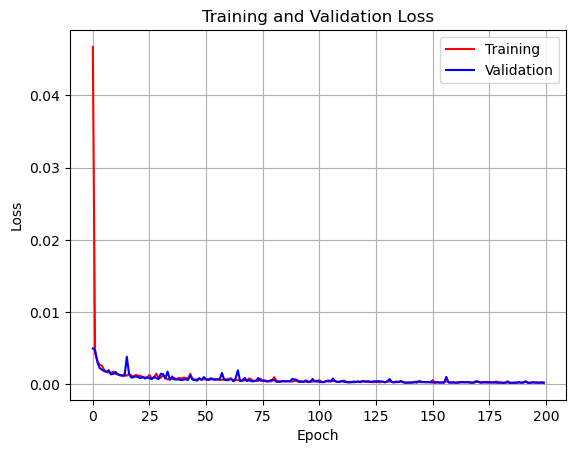

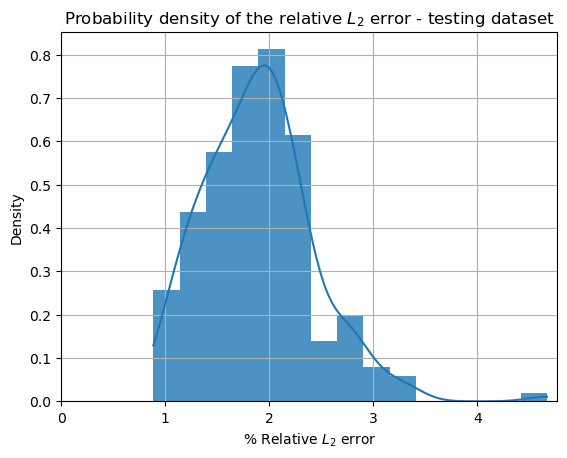

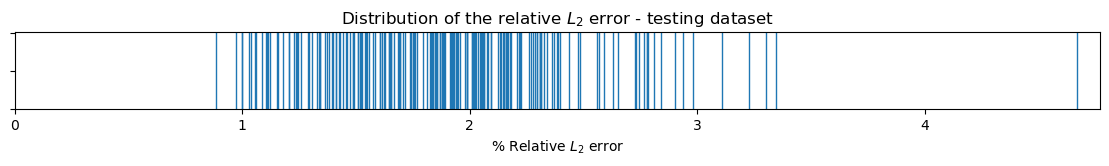

In [12]:
# train and validate model
varmion.training_validation(verbose = True)


result_dict['lambda'] = varmion.lam # parameter used in the loss function for extra boundary points, 0 by default
result_dict['best_epoch'] = varmion.best_epoch # index of the epoch with lowest validation loss, we save the weights relative to this epoch
with open(save_dir + "/result_dict", "wb") as handle:
    pickle.dump(result_dict, handle)


# plot and save losses
varmion.plot_losses(save_dir= save_dir)

# compute and then plot and save the relative L^2-error on the testing dataset, 
varmion.testing(save_dir = save_dir)

# save data in the result folder
#M si potrebbe inserire dentro la classe varmion
torch.save(varmion.model.state_dict(), save_dir + '/model_weights_best.pth')
torch.save(varmion.losses, save_dir + "/losses.pt")
torch.save(varmion.val_losses, save_dir + "/val_losses.pt")
torch.save(varmion.test_error_best, save_dir + "/test_error_best.pt")
torch.save(varmion.test_abs_error_best, save_dir + "/test_abs_error_best.pt")

# Comparison numerical solution and prediction of a pde instance


In [15]:

# load data relative to a pde
index = 1990
pde_data = torch.utils.data.Subset(dataset, [index])

# path of the directory containing the weights to be used for the prediction
weights_dir = save_dir + '/model_weights_best.pth'

# create a model and send it to device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"{device = }")
model = HeatEquationVarMiONRobin()
model.load_state_dict(torch.load(weights_dir, weights_only = True)) ## put correct path
model.to(device)
# set to eval mode
model.eval()


# create a dataloader
loader = DataLoader(pde_data, batch_size=1)
            
# compute predictions
for j, test_data in enumerate(loader): 
            
    X = [elem.to(device) for elem in test_data[:-1]]
    y = test_data[-1]
        
    with torch.no_grad():  
        pred = model(X)
#endfor
        

device = 'cuda'


/tmp/ipykernel_18603/277317821.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


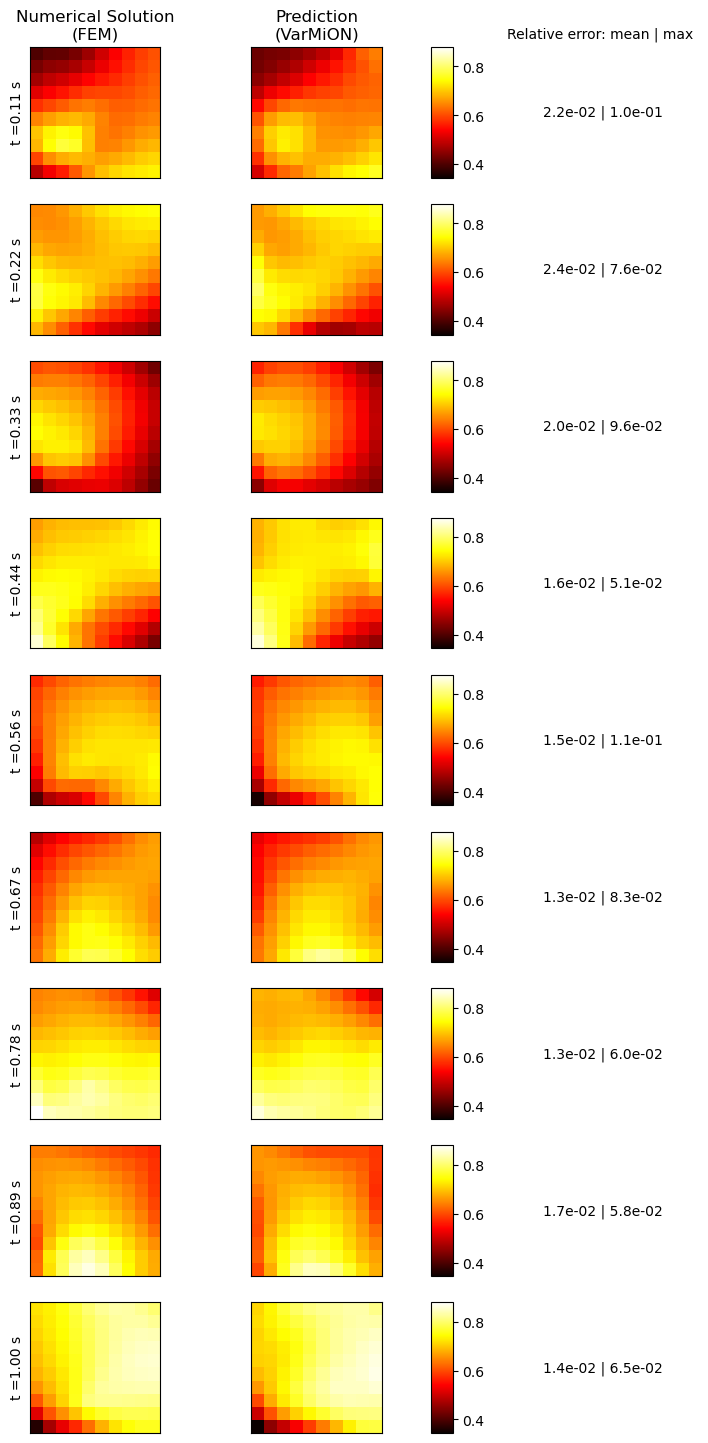

In [16]:
n_times = 9  # Number of time steps
array0 = dataset.data['solution'][index,:,:100].numpy().reshape(n_times,10,10) #(n_times, 10, 10)
array1 = pred[0,:,:100].cpu().numpy().reshape(n_times,10,10) #(n_times, 10, 10)


diff = np.abs(array0 - array1).reshape(n_times, 100)
errors_max = np.max(diff, axis=1)
errors_mean = np.mean(diff, axis=1)
err_rel = np.abs((array0 - array1)/array0).reshape(n_times, 100)
rel_errs_max = np.max(err_rel, axis=1)
rel_errs_mean = np.mean(err_rel, axis=1)


# Get global color scale limits
vmin = min(array0.min(), array1.min())
vmax = max(array0.max(), array1.max())

# Create figure
fig = plt.figure(figsize=(6, 2 * n_times))  # Adjust size as needed
gs = gridspec.GridSpec(n_times, 3, width_ratios=[1, 1, 0.1], wspace=0.05)

# Create subplots for each time step
for t in range(n_times):
    ax1 = plt.subplot(gs[t, 0])
    ax2 = plt.subplot(gs[t, 1])
    cbar_ax = plt.subplot(gs[t, 2])

    im1 = ax1.imshow(array0[t], vmin=vmin, vmax=vmax, cmap="hot")
    im2 = ax2.imshow(array1[t], vmin=vmin, vmax=vmax, cmap="hot")
    
    ax1.set_ylabel(f't ={(t+1)/n_times:.2f} s')

    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.set_xticks([])
    ax2.set_yticks([])

    if t==0:
        ax1.set_title("Numerical Solution\n(FEM)")
        ax2.set_title("Prediction\n(VarMiON)")
         
    fig.colorbar(im2, cax=cbar_ax)
    
    if t==0:
        fig.text(8, 1.1, "Relative error: mean | max ", fontsize=10, ha="center", va="center", transform=cbar_ax.transAxes)

    rel_error_text = f"{rel_errs_mean[t]:.1e} | {rel_errs_max[t]:.1e}"
    fig.text(8, 0.5, rel_error_text, fontsize=10, ha="center", va="center", transform=cbar_ax.transAxes)

plt.tight_layout()
plt.show()